# Check if we can get trigger codes from openBCI GUI recording

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mne 

from glob import glob  

In [2]:
# data_files = glob('./*data/*19.txt')
data_files = glob('./*data/*durations.txt')
print(data_files)

['.\\Cyton_data\\trigger_durations.txt']


In [3]:
# df = pd.concat([pd.read_csv(f, skiprows=4) for f in data_files], ignore_index=True)

df = pd.read_csv(data_files[0], skiprows=4, skipinitialspace=True)#.reset_index()

In [4]:
df.drop(columns=["Not Used", "Not Used.1", "Accel Channel 0", "Accel Channel 1", "Accel Channel 2", "Analog Channel 0", "Analog Channel 1", "Analog Channel 2"], inplace=True)
df.columns

Index(['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2',
       'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6',
       'EXG Channel 7', 'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)',
       'Digital Channel 2 (D13)', 'Digital Channel 3 (D17)',
       'Digital Channel 4 (D18)', 'Timestamp', 'Marker Channel',
       'Timestamp (Formatted)'],
      dtype='object')

<Axes: >

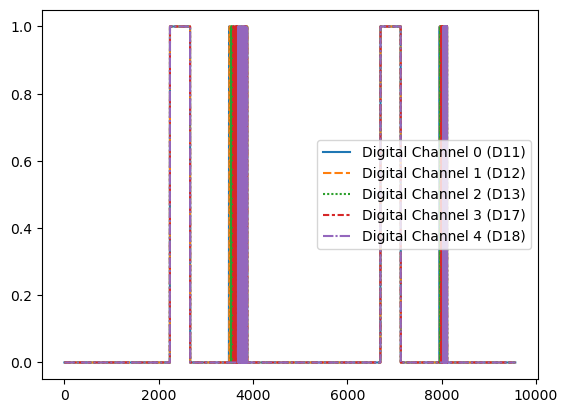

In [5]:
sfreq = 250
ch_names = df.columns[1:].tolist()

digi_cols = [col for col in ch_names if col.startswith('Digital')]

digi_df = df[digi_cols]

sns.lineplot(data=digi_df)

In [6]:
# Get the 5 digital channels (assuming they correspond to the 5 trigger pins)
# The digital channels should be in order: D11, D12, D13, D17, D18 (or similar)
digi_cols = [col for col in df.columns if col.startswith('Digital')]
print(f"Digital channels found: {digi_cols}")

# Create a function to decode 5-bit trigger codes
def decode_trigger_codes(digi_df):
    """
    Decode 5-bit trigger codes from digital channels.
    Each row's digital channels represent bits 0-4 of the trigger code.
    Returns a Series with the decoded trigger code (0-31) for each sample.
    """
    # Convert to boolean/binary
    binary_df = digi_df.astype(bool).astype(int)
    
    # For reverse mapping (if needed)
    # trigger_codes = (
    #     binary_df.iloc[:, 0] * (2**4) +
    #     binary_df.iloc[:, 1] * (2**3) +
    #     binary_df.iloc[:, 2] * (2**2) +
    #     binary_df.iloc[:, 3] * (2**1) +
    #     binary_df.iloc[:, 4] * (2**0)
    # )
    
    # Combine the 5 bits into a single code (0-31)
    # Assuming columns are ordered from LSB to MSB (bit 0 to bit 4)
    trigger_codes = (
        binary_df.iloc[:, 0] * (2**0) +
        binary_df.iloc[:, 1] * (2**1) +
        binary_df.iloc[:, 2] * (2**2) +
        binary_df.iloc[:, 3] * (2**3) +
        binary_df.iloc[:, 4] * (2**4)
    )
    
    return trigger_codes


Digital channels found: ['Digital Channel 0 (D11)', 'Digital Channel 1 (D12)', 'Digital Channel 2 (D13)', 'Digital Channel 3 (D17)', 'Digital Channel 4 (D18)']


# Decode triggers and add as a column


Found 1016 trigger events found


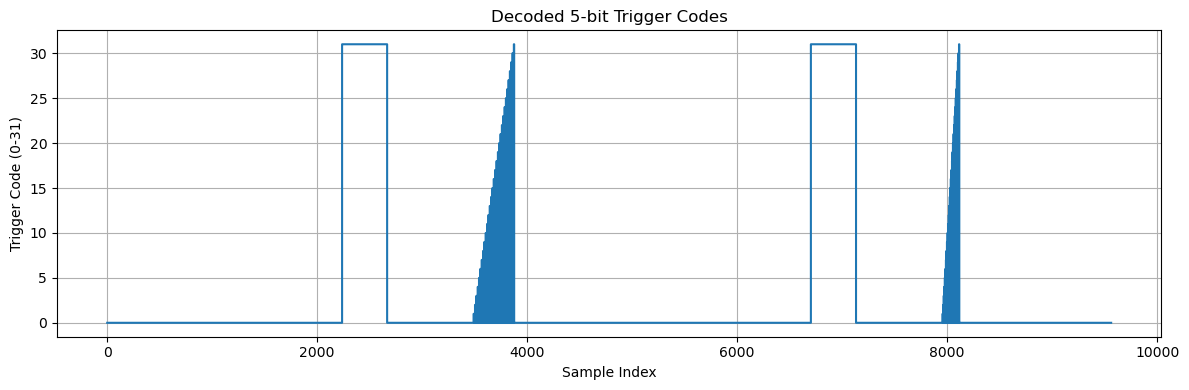

In [7]:
# Decode the trigger codes
df['Trigger_Code'] = decode_trigger_codes(digi_df)

# Find non-zero trigger events
trigger_events = df[df['Trigger_Code'] > 0][['Trigger_Code']]
print(f"\nFound {len(trigger_events)} trigger events found")
# print("\nTrigger codes detected:")
# print(trigger_events['Trigger_Code'].value_counts().sort_index())

# Plot the trigger codes over time
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Trigger_Code'], drawstyle='steps-post')
plt.xlabel('Sample Index')
plt.ylabel('Trigger Code (0-31)')
plt.title('Decoded 5-bit Trigger Codes')
plt.grid(True)
plt.tight_layout()
plt.show()

## Add a `ttrigger_present` column to indicate if any trigger is present 

In [8]:
df

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Digital Channel 0 (D11),Digital Channel 1 (D12),Digital Channel 2 (D13),Digital Channel 3 (D17),Digital Channel 4 (D18),Timestamp,Marker Channel,Timestamp (Formatted),Trigger_Code
0,0.0,-180277.458462,-183949.157172,-184240.310996,-183062.262304,-186361.536248,-186243.295520,-181375.219688,-187500.022352,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:09:43.601,0
1,1.0,-180275.893840,-183948.128992,-184239.372222,-183061.256476,-186360.552771,-186242.580264,-181373.789176,-187500.022352,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:09:43.604,0
2,2.0,-180276.206765,-183948.956007,-184240.154533,-183062.061138,-186361.156268,-186243.407278,-181374.079749,-187500.022352,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:09:43.608,0
3,3.0,-180276.206765,-183949.470097,-184240.579217,-183062.329359,-186361.312730,-186243.921369,-181373.766824,-187500.022352,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:09:43.612,0
4,4.0,-180275.290343,-183948.911303,-184239.931016,-183061.748214,-186360.485716,-186243.429630,-181372.559830,-187500.022352,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:09:43.616,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9558,86.0,-166092.147361,-174691.913985,-175210.742678,-173477.342543,-174163.697560,-178745.559304,-164813.068785,-186308.048523,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:10:21.738,0
9559,87.0,-166091.610919,-174692.048096,-175210.720326,-173477.253136,-174163.161118,-178745.604008,-164811.973549,-186308.160282,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:10:21.742,0
9560,88.0,-166088.459323,-174689.544700,-175208.216930,-173474.772093,-174160.367150,-178743.435889,-164808.620788,-186306.126273,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:10:21.747,0
9561,89.0,-166085.553597,-174687.197767,-175206.071163,-173472.581622,-174157.774348,-178741.468935,-164805.580950,-186304.449893,0.0,0.0,0.0,0.0,0.0,1.763583e+09,0.0,2025-11-19 16:10:21.751,0


Samples with triggers present:
      Trigger_Code  Trigger_Present
2237            31             31.0
2238            31             31.0
2239            31             31.0
2240            31             31.0
2241            31             31.0
...            ...              ...
8107            30             30.0
8108            30             30.0
8109            30             30.0
8113            31             31.0
8114            31             31.0

[1016 rows x 2 columns]


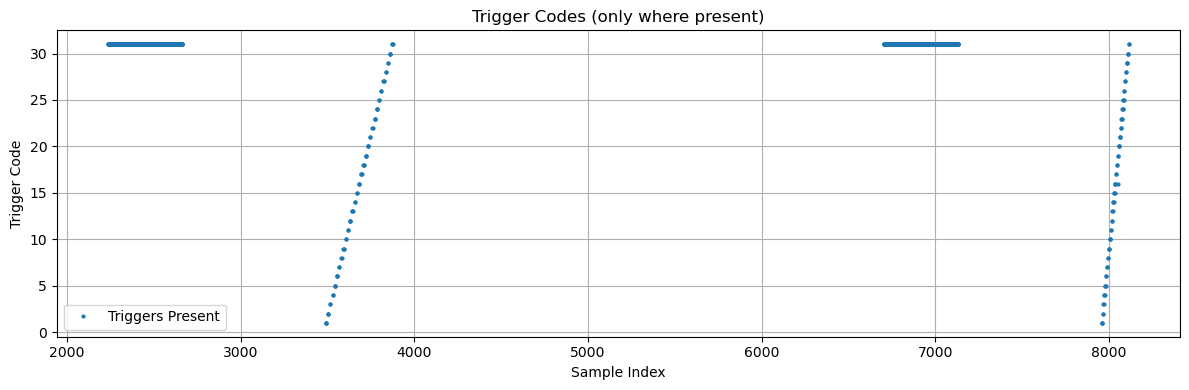

In [9]:
# Create a column with trigger codes, showing NaN where code is 0
df['Trigger_Present'] = df['Trigger_Code'].replace(0, np.nan)

# Or if you want to keep the column but only show values > 0
df['Trigger_Present'] = df['Trigger_Code'].where(df['Trigger_Code'] > 0)

# View the result
print("Samples with triggers present:")
print(df[df['Trigger_Present'].notna()][['Trigger_Code', 'Trigger_Present']])


# Plot to verify
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Trigger_Present'], 'o', markersize=2, label='Triggers Present')
plt.xlabel('Sample Index')
plt.ylabel('Trigger Code')
plt.title('Trigger Codes (only where present)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()